# Facial Emotion Recognition - Resnet 18
### Introduction
The aim of this project is to predict the age, gender and emotion of a person from an image of their face using artificial neural networks trained on images from the FER-2013 facial recognition dataset.

We investigate the accuracy of age, gender and emotion prediction using use different neural network models. We evaluate each model using accuracy, F1 score, L1 mean absolute error, and training time.

This notebook predicts facial emotion using a Resnet 18 neural network model.

In [ ]:
!pip install poutyne
!pip install torchsummary
!pip install graphviz
!pip install torchviz

In [1]:
import os
import tarfile
import urllib.request
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
from torch.utils import model_zoo
from torch.utils.data import Subset, DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.transforms.functional import InterpolationMode
import torchvision.models as models

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, EarlyStopping, ReduceLROnPlateau
from zipfile import ZipFile
from torchsummary import summary
from torchviz import make_dot

## Down and prepare the FER 2013 dataset

In [2]:
set_seeds(42)
base_path = './datasets/fer_2013'
zip_file_name = 'fer_2013.zip'
base_image_path = os.path.join(base_path, 'images')
zip_url = 'https://storage.googleapis.com/unsw_comp9444/fer_2103/fer_2013.zip'

#### Download and extract dataset images
Dataset: https://www.kaggle.com/datasets/msambare/fer2013

In [3]:
def download_and_extract_dataset(base_path, extract_path, file_name, zip_url):
    os.makedirs(base_path, exist_ok=True)
    os.makedirs(extract_path, exist_ok=True)
    zip_filename = os.path.join(base_path, file_name)

    print('Downloading dataset...')
    urllib.request.urlretrieve(zip_url, zip_filename)
    print('Extracting archive...')
    with ZipFile(zip_filename, 'r') as zip_obj:
       zip_obj.extractall(path=extract_path)
    
download_and_extract_dataset(base_path, base_image_path, zip_file_name, zip_url)    

Extracting archive...


#### Setup training constants

In [4]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

num_classes = 7
batch_size = 32
test_batch_size = 128
learning_rate = 0.0001
weight_decay = 0.001
n_epoch = 50
image_size = 48

#### Create datasets and image transforms

In [5]:
augment_transform = transforms.Compose(
    [                
        transforms.RandomAffine(degrees = 5, translate = (0.1, 0.1), shear = 5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

normalize_transform = transforms.Compose(
    [        
        #transforms.Resize(224, interpolation=InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

train_image_path = os.path.join(base_image_path, 'train')
test_image_path = os.path.join(base_image_path, 'test')

train_dataset = ImageFolder(
    train_image_path,
    transform=normalize_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

test_valid_dataset = ImageFolder(
    test_image_path,
    transform=normalize_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

Use 50% of the test dataset for validation

In [6]:
test_dataset_size = int(len(test_valid_dataset) * 0.5)
dataset_lengths = [test_dataset_size, len(test_valid_dataset) - test_dataset_size]
test_dataset, valid_dataset = random_split(test_valid_dataset, dataset_lengths)

#### Example face images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

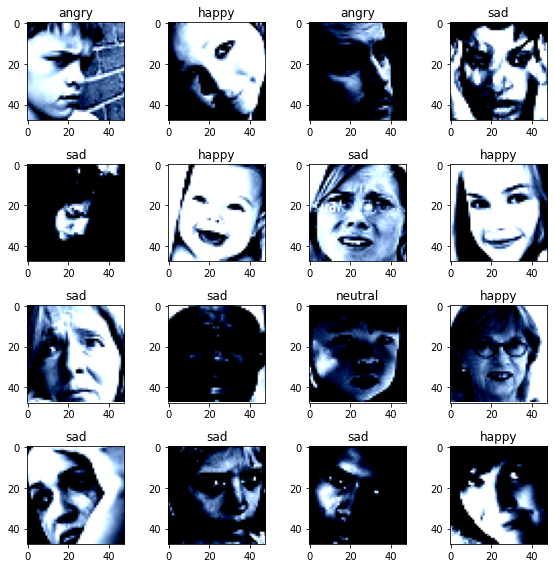

In [7]:
def show_batch(dataset):
    random_index = np.random.randint(0, len(dataset) -1, size=16)
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i, image_index in enumerate(random_index):
        (image, label) = dataset[image_index]
        ax[i % 4, i // 4].set_title(dataset.classes[label])
        ax[i % 4, i // 4].imshow(image.permute(1, 2, 0), cmap='gray')
            
    fig.tight_layout()
    fig.show()
            
show_batch(test_valid_dataset)          

#### Dataset sizes and classes

In [8]:
print(f'training dataset size: {len(train_dataset)}')
print(f'validaiton dataset size: {len(valid_dataset)}')
print(f'test dataset size: {len(test_dataset)}')

print(f'classes: {train_dataset.classes}')
print(f'class indexes: {train_dataset.class_to_idx}')

training dataset size: 28709
validaiton dataset size: 3589
test dataset size: 3589
classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class indexes: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


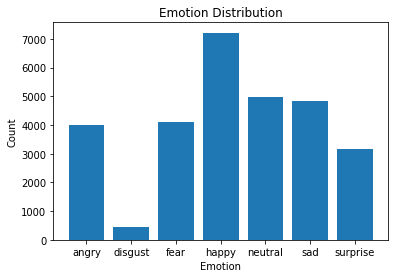

In [9]:
emotion_counts = dict(Counter(train_dataset.targets))

emotion_names = [train_dataset.classes[i] for i in list(emotion_counts.keys())]
emotion_values = list(emotion_counts.values())
plt.bar(range(len(emotion_counts)), emotion_values, tick_label=emotion_names)
plt.title("Emotion Distribution")
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.savefig('plots/faces/emotion_distribution.png')
plt.show()

#### Create dataloaders for train, validation and test datasets

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, num_workers=0)

## Create CNN model for facial emotion recognition and classification

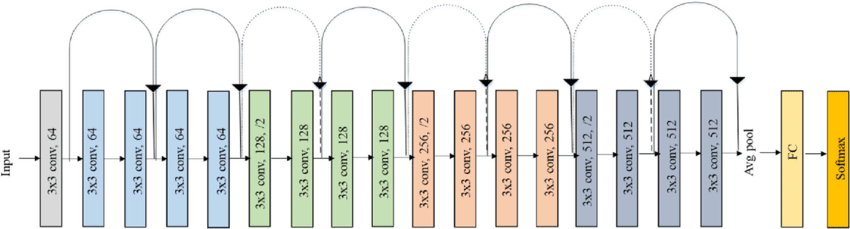

In [11]:
class ResnetFaceNetwork(nn.Module):
    def __init__(self):
        super(ResnetFaceNetwork, self).__init__()        
        self.resnet = models.resnet18(pretrained=True)
        self.num_features = self.resnet.fc.in_features

        self.fc_output = nn.Linear(self.num_features, num_classes)
    def forward(self, input):      
        output = self.resnet(input)
        
        return output
    
resnet_face_network = ResnetFaceNetwork().to(device)
print(summary(resnet_face_network, input_size=(3, image_size, image_size)))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           9,408
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          36,864
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
       BasicBlock-11           [-1, 64, 12, 12]               0
           Conv2d-12           [-1, 64, 12, 12]          36,864
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

## Train the CNN for facial emotion classification on the FER 2013 dataset
#### Create training callbacks for saving last epoch, best epoch, reducing learning rate, early stopping and logging the results

In [12]:
# We are saving everything into ./saves/cub200.
save_base_dir = 'saves'
save_path = os.path.join(save_base_dir, 'fer_faces_resnet')
os.makedirs(save_path, exist_ok=True)

plots_dir = 'plots/resnet'
os.makedirs(plots_dir, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    #EarlyStopping(patience=15, verbose=True),
    ReduceLROnPlateau(monitor='val_loss', verbose=True),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

#### Create training optimizer, loss function and Poutyne model. Train the CNN network and evaluate validation and test datsets

In [13]:
trainable_parameters = (parameter for name, parameter in resnet_face_network.named_parameters() if parameter.requires_grad)
optimizer = optim.Adam(trainable_parameters, lr=learning_rate, weight_decay=weight_decay)

loss_function = nn.CrossEntropyLoss()

model = Model(
    resnet_face_network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1'],
    device=device,
)

model.fit_generator(
    train_loader,
    valid_loader,
    epochs=n_epoch,
    callbacks=callbacks    
)

test_loss, (test_acc, test_f1), y_predict, y_true = model.evaluate_generator(test_loader, return_pred=True, return_ground_truth=True)

Epoch:  1/50 Train steps: 898 Val steps: 29 51.83s loss: 2.253313 acc: 41.457383 fscore_macro: 0.002470 val_loss: 1.288246 val_acc: 53.190304 val_fscore_macro: 0.003167
Epoch 1: val_acc improved from -inf to 53.19030, saving file to saves\fer_faces_resnet\best_epoch_1.ckpt
Epoch:  2/50 Train steps: 898 Val steps: 29 54.72s loss: 1.165030 acc: 56.860218 fscore_macro: 0.003649 val_loss: 1.195319 val_acc: 56.199498 val_fscore_macro: 0.003628
Epoch 2: val_acc improved from 53.19030 to 56.19950, saving file to saves\fer_faces_resnet\best_epoch_2.ckpt
Epoch:  3/50 Train steps: 898 Val steps: 29 59.99s loss: 0.972676 acc: 64.032185 fscore_macro: 0.004318 val_loss: 1.152134 val_acc: 59.821677 val_fscore_macro: 0.004050
Epoch 3: val_acc improved from 56.19950 to 59.82168, saving file to saves\fer_faces_resnet\best_epoch_3.ckpt
Epoch:  4/50 Train steps: 898 Val steps: 29 57.27s loss: 0.792526 acc: 70.796614 fscore_macro: 0.004849 val_loss: 1.212628 val_acc: 57.982725 val_fscore_macro: 0.003956
E

## Print results, accuracy and confusion matrix

In [14]:
logs = pd.read_csv(os.path.join(save_path, 'log.tsv'), sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

    epoch       time            lr      loss        acc  fscore_macro  \
0       1  51.831316  1.000000e-04  2.253313  41.457383      0.002470   
1       2  54.716102  1.000000e-04  1.165030  56.860218      0.003649   
2       3  59.987181  1.000000e-04  0.972676  64.032185      0.004318   
3       4  57.270743  1.000000e-04  0.792526  70.796614      0.004849   
4       5  57.381333  1.000000e-04  0.624970  77.226654      0.005334   
5       6  55.187157  1.000000e-04  0.481964  82.562959      0.005716   
6       7  56.629443  1.000000e-04  0.368183  87.094639      0.006085   
7       8  55.023899  1.000000e-04  0.299316  89.494584      0.006236   
8       9  56.863648  1.000000e-04  0.249790  91.396426      0.006356   
9      10  57.824962  1.000000e-04  0.216190  92.392629      0.006432   
10     11  56.019163  1.000000e-04  0.196904  93.305235      0.006501   
11     12  56.584777  1.000000e-04  0.179319  93.911317      0.006558   
12     13  56.428175  1.000000e-04  0.166220  94.29

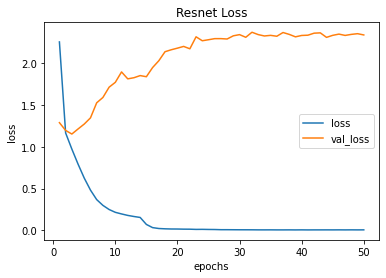

In [15]:
metrics = ['loss', 'val_loss']
plt.title('Resnet Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/resnet/emotion_loss.png')
plt.show()

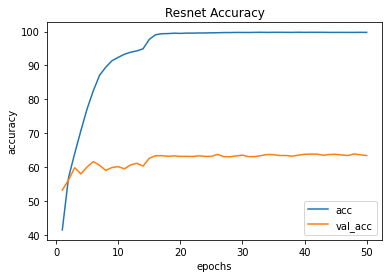

In [16]:
metrics = ['acc', 'val_acc']
plt.title('Resnet Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/resnet/emotion_accuracy.png')
plt.show()

Text(87.0, 0.5, 'Prediction')

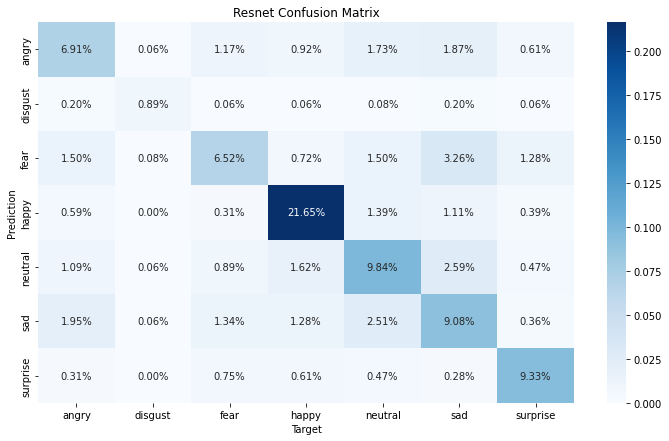

In [17]:
cf_matrix = confusion_matrix(y_true, np.argmax(y_predict, axis=1))
class_names = train_dataset.classes

plt.figure(figsize = (12,7))
plt.title('Resnet Confusion Matrix')
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.savefig('plots/resnet/emotion_confusion_matrix.png')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.show()